In [2]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
from common import *
from seagul.mesh import create_mesh, variation_dim, mesh_dim
import scipy.optimize as opt
import torch
import matplotlib.pyplot as plt
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os


def do_rollout_till_fail(env, policy, ep_length, fail_cond):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if fail_cond(obs):
            break

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length



In [15]:
env_name = "Walker2d-v2"
data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
data = torch.load(f"./data17/{env_name}.xr")
policy_dict['identity'] = data.policy_dict['identity']
#policy_dict['identity'] = data.policy_dict['identity']

post_fns = [identity, mdim_div]
num_seeds = 10
num_runs = 10
ep_length = 100000

def fail_fn(o):
    return not (-1 < o[1] < 1)


In [70]:
run_ls = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

env = gym.make(env_name)

for post_fn in post_fns:
    for i in range(num_seeds):
        policy = policy_dict[post_fn.__name__][i]
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][i]
            o,a,r,l = do_rollout_till_fail(env, policy, ep_length= ep_length, fail_cond=fail_fn)
            run_ls.loc[post_fn.__name__,i,j] = l 

In [71]:
run_bin = run_ls.where(run_ls == 100000, 0)/100000

In [74]:
run_bin.sum(dim='run').mean(dim='seed').to_pandas()

post
identity    3.2
mdim_div    8.8
dtype: float64

In [61]:
run_bin.to_pandas()

ValueError: cannot convert arrays with 3 dimensions into pandas objects

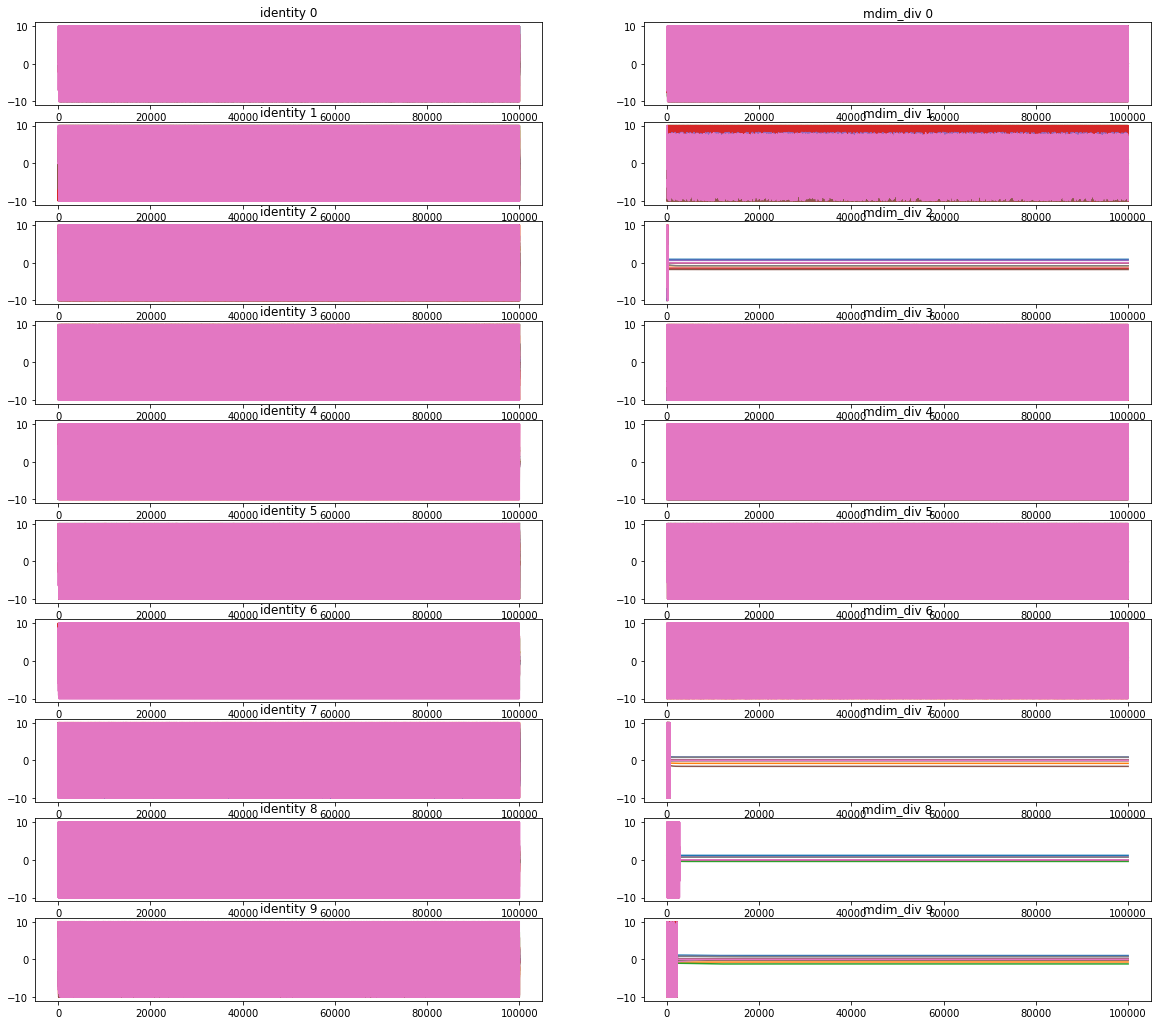

In [17]:
env = gym.make(env_name)
fig, axes = plt.subplots(10,2, figsize=(20, 18))
ep_length=100000
for i,seed in enumerate(range(10)):
    for j,post in enumerate(['identity', 'mdim_div']):
        policy = policy_dict[post][seed]
        obs, acts, rews, l = do_long_rollout(env, policy, ep_length)
        axes[i,j].plot(obs)
        axes[i,j].set_title(f"{post} {seed}")
    